<a href="https://colab.research.google.com/github/Code-CloudSG/CS506-Computational-Tools-for-Data-Science/blob/master/success_audio_preprocessing_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cd gdrive/My Drive/project_folder/speech
!pwd

/content/gdrive/My Drive/project_folder/speech
/content/gdrive/My Drive/project_folder/speech



Audio manipulation with torchaudio
==================================

``torchaudio`` provides powerful audio I/O functions, preprocessing
transforms and dataset.

In this tutorial, we will look into how to prepare audio data and
extract features that can be fed to NN models.




In [ ]:
# When running this tutorial in Google Colab, install the required packages
# with the following.
# !pip install torchaudio librosa boto3

import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T

print(torch.__version__)
print(torchaudio.__version__)

1.9.0+cu102
0.9.0


In [ ]:
!pip install torchaudio

     |████████████████████████████████| 1.9MB 16.3MB/s 


Preparing data and utility functions (skip this section)
--------------------------------------------------------




In [ ]:
#@title Prepare data and utility functions. {display-mode: "form"}
#@markdown
#@markdown You do not need to look into this cell.
#@markdown Just execute once and you are good to go.
#@markdown
#@markdown In this tutorial, we will use a speech data from [VOiCES dataset](https://iqtlabs.github.io/voices/), which is licensed under Creative Commos BY 4.0.

#-------------------------------------------------------------------------------
# Preparation of data and helper functions.
#-------------------------------------------------------------------------------
import io
import os
import math
import tarfile
import multiprocessing

import scipy
import librosa
import boto3
from botocore import UNSIGNED
from botocore.config import Config
import requests
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import time
from IPython.display import Audio, display

[width, height] = matplotlib.rcParams['figure.figsize']
if width < 10:
  matplotlib.rcParams['figure.figsize'] = [width * 2.5, height]

_SAMPLE_DIR = "_sample_data"
SAMPLE_WAV_URL = "https://pytorch-tutorial-assets.s3.amazonaws.com/steam-train-whistle-daniel_simon.wav"
SAMPLE_WAV_PATH = os.path.join(_SAMPLE_DIR, "steam.wav")

SAMPLE_WAV_SPEECH_URL = "https://pytorch-tutorial-assets.s3.amazonaws.com/VOiCES_devkit/source-16k/train/sp0307/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav"
SAMPLE_WAV_SPEECH_PATH = os.path.join(_SAMPLE_DIR, "speech.wav")

SAMPLE_RIR_URL = "https://pytorch-tutorial-assets.s3.amazonaws.com/VOiCES_devkit/distant-16k/room-response/rm1/impulse/Lab41-SRI-VOiCES-rm1-impulse-mc01-stu-clo.wav"
SAMPLE_RIR_PATH = os.path.join(_SAMPLE_DIR, "rir.wav")

SAMPLE_NOISE_URL = "https://pytorch-tutorial-assets.s3.amazonaws.com/VOiCES_devkit/distant-16k/distractors/rm1/babb/Lab41-SRI-VOiCES-rm1-babb-mc01-stu-clo.wav"
SAMPLE_NOISE_PATH = os.path.join(_SAMPLE_DIR, "bg.wav")

SAMPLE_MP3_URL = "https://pytorch-tutorial-assets.s3.amazonaws.com/steam-train-whistle-daniel_simon.mp3"
SAMPLE_MP3_PATH = os.path.join(_SAMPLE_DIR, "steam.mp3")

SAMPLE_GSM_URL = "https://pytorch-tutorial-assets.s3.amazonaws.com/steam-train-whistle-daniel_simon.gsm"
SAMPLE_GSM_PATH = os.path.join(_SAMPLE_DIR, "steam.gsm")

SAMPLE_TAR_URL = "https://pytorch-tutorial-assets.s3.amazonaws.com/VOiCES_devkit.tar.gz"
SAMPLE_TAR_PATH = os.path.join(_SAMPLE_DIR, "sample.tar.gz")
SAMPLE_TAR_ITEM = "VOiCES_devkit/source-16k/train/sp0307/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav"

S3_BUCKET = "pytorch-tutorial-assets"
S3_KEY = "VOiCES_devkit/source-16k/train/sp0307/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav"

YESNO_DATASET_PATH = os.path.join(_SAMPLE_DIR, "yes_no")
os.makedirs(YESNO_DATASET_PATH, exist_ok=True)
os.makedirs(_SAMPLE_DIR, exist_ok=True)

def _fetch_data():
  uri = [
    (SAMPLE_WAV_URL, SAMPLE_WAV_PATH),
    (SAMPLE_WAV_SPEECH_URL, SAMPLE_WAV_SPEECH_PATH),
    (SAMPLE_RIR_URL, SAMPLE_RIR_PATH),
    (SAMPLE_NOISE_URL, SAMPLE_NOISE_PATH),
    (SAMPLE_MP3_URL, SAMPLE_MP3_PATH),
    (SAMPLE_GSM_URL, SAMPLE_GSM_PATH),
    (SAMPLE_TAR_URL, SAMPLE_TAR_PATH),
  ]
  for url, path in uri:
    with open(path, 'wb') as file_:
      file_.write(requests.get(url).content)

_fetch_data()

def _download_yesno():
  if os.path.exists(os.path.join(YESNO_DATASET_PATH, "waves_yesno.tar.gz")):
    return
  torchaudio.datasets.YESNO(root=YESNO_DATASET_PATH, download=True)

YESNO_DOWNLOAD_PROCESS = multiprocessing.Process(target=_download_yesno)
YESNO_DOWNLOAD_PROCESS.start()

def _get_sample(path, resample=None):
  effects = [
    ["remix", "1"]
  ]
  if resample:
    effects.extend([
      ["lowpass", f"{resample // 2}"],
      ["rate", f'{resample}'],
    ])
  return torchaudio.sox_effects.apply_effects_file(path, effects=effects)

def get_speech_sample(*, resample=None):
  return _get_sample(SAMPLE_WAV_SPEECH_PATH, resample=resample)

def get_sample(*, resample=None):
  return _get_sample(SAMPLE_WAV_PATH, resample=resample)

def get_rir_sample(*, resample=None, processed=False):
  rir_raw, sample_rate = _get_sample(SAMPLE_RIR_PATH, resample=resample)
  if not processed:
    return rir_raw, sample_rate
  rir = rir_raw[:, int(sample_rate*1.01):int(sample_rate*1.3)]
  rir = rir / torch.norm(rir, p=2)
  rir = torch.flip(rir, [1])
  return rir, sample_rate

def get_noise_sample(*, resample=None):
  return _get_sample(SAMPLE_NOISE_PATH, resample=resample)

def print_stats(waveform, sample_rate=None, src=None):
  if src:
    print("-" * 10)
    print("Source:", src)
    print("-" * 10)
  if sample_rate:
    print("Sample Rate:", sample_rate)
  print("Shape:", tuple(waveform.shape))
  print("Dtype:", waveform.dtype)
  print(f" - Max:     {waveform.max().item():6.3f}")
  print(f" - Min:     {waveform.min().item():6.3f}")
  print(f" - Mean:    {waveform.mean().item():6.3f}")
  print(f" - Std Dev: {waveform.std().item():6.3f}")
  print()
  print(waveform)
  print()

def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].plot(time_axis, waveform[c], linewidth=1)
    axes[c].grid(True)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
    if ylim:
      axes[c].set_ylim(ylim)
  figure.suptitle(title)
  plt.show(block=False)

def plot_specgram(waveform, sample_rate, title="Spectrogram", xlim=None):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].specgram(waveform[c], Fs=sample_rate)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
  figure.suptitle(title)
  plt.show(block=False)

def play_audio(waveform, sample_rate):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  if num_channels == 1:
    display(Audio(waveform[0], rate=sample_rate))
  elif num_channels == 2:
    display(Audio((waveform[0], waveform[1]), rate=sample_rate))
  else:
    raise ValueError("Waveform with more than 2 channels are not supported.")

def inspect_file(path):
  print("-" * 10)
  print("Source:", path)
  print("-" * 10)
  print(f" - File size: {os.path.getsize(path)} bytes")
  print(f" - {torchaudio.info(path)}")

def plot_spectrogram(spec, title=None, ylabel='freq_bin', aspect='auto', xmax=None):
  fig, axs = plt.subplots(1, 1)
  axs.set_title(title or 'Spectrogram (db)')
  axs.set_ylabel(ylabel)
  axs.set_xlabel('frame')
  im = axs.imshow(librosa.power_to_db(spec), origin='lower', aspect=aspect)
  if xmax:
    axs.set_xlim((0, xmax))
  fig.colorbar(im, ax=axs)
  plt.show(block=False)

def plot_mel_fbank(fbank, title=None):
  fig, axs = plt.subplots(1, 1)
  axs.set_title(title or 'Filter bank')
  axs.imshow(fbank, aspect='auto')
  axs.set_ylabel('frequency bin')
  axs.set_xlabel('mel bin')
  plt.show(block=False)

def get_spectrogram(
    n_fft = 400,
    win_len = None,
    hop_len = None,
    power = 2.0,
):
  waveform, _ = get_speech_sample()
  spectrogram = T.Spectrogram(
      n_fft=n_fft,
      win_length=win_len,
      hop_length=hop_len,
      center=True,
      pad_mode="reflect",
      power=power,
  )
  return spectrogram(waveform)

def plot_pitch(waveform, sample_rate, pitch):
  figure, axis = plt.subplots(1, 1)
  axis.set_title("Pitch Feature")
  axis.grid(True)

  end_time = waveform.shape[1] / sample_rate
  time_axis = torch.linspace(0, end_time,  waveform.shape[1])
  axis.plot(time_axis, waveform[0], linewidth=1, color='gray', alpha=0.3)

  axis2 = axis.twinx()
  time_axis = torch.linspace(0, end_time, pitch.shape[1])
  ln2 = axis2.plot(
      time_axis, pitch[0], linewidth=2, label='Pitch', color='green')

  axis2.legend(loc=0)
  plt.show(block=False)

def plot_kaldi_pitch(waveform, sample_rate, pitch, nfcc):
  figure, axis = plt.subplots(1, 1)
  axis.set_title("Kaldi Pitch Feature")
  axis.grid(True)

  end_time = waveform.shape[1] / sample_rate
  time_axis = torch.linspace(0, end_time,  waveform.shape[1])
  axis.plot(time_axis, waveform[0], linewidth=1, color='gray', alpha=0.3)

  time_axis = torch.linspace(0, end_time, pitch.shape[1])
  ln1 = axis.plot(time_axis, pitch[0], linewidth=2, label='Pitch', color='green')
  axis.set_ylim((-1.3, 1.3))

  axis2 = axis.twinx()
  time_axis = torch.linspace(0, end_time, nfcc.shape[1])
  ln2 = axis2.plot(
      time_axis, nfcc[0], linewidth=2, label='NFCC', color='blue', linestyle='--')

  lns = ln1 + ln2
  labels = [l.get_label() for l in lns]
  axis.legend(lns, labels, loc=0)
  plt.show(block=False)

DEFAULT_OFFSET = 201
SWEEP_MAX_SAMPLE_RATE = 48000
DEFAULT_LOWPASS_FILTER_WIDTH = 6
DEFAULT_ROLLOFF = 0.99
DEFAULT_RESAMPLING_METHOD = 'sinc_interpolation'

def _get_log_freq(sample_rate, max_sweep_rate, offset):
  """Get freqs evenly spaced out in log-scale, between [0, max_sweep_rate // 2]

  offset is used to avoid negative infinity `log(offset + x)`.

  """
  half = sample_rate // 2
  start, stop = math.log(offset), math.log(offset + max_sweep_rate // 2)
  return torch.exp(torch.linspace(start, stop, sample_rate, dtype=torch.double)) - offset

def _get_inverse_log_freq(freq, sample_rate, offset):
  """Find the time where the given frequency is given by _get_log_freq"""
  half = sample_rate // 2
  return sample_rate * (math.log(1 + freq / offset) / math.log(1 + half / offset))

def _get_freq_ticks(sample_rate, offset, f_max):
  # Given the original sample rate used for generating the sweep,
  # find the x-axis value where the log-scale major frequency values fall in
  time, freq = [], []
  for exp in range(2, 5):
    for v in range(1, 10):
      f = v * 10 ** exp
      if f < sample_rate // 2:
        t = _get_inverse_log_freq(f, sample_rate, offset) / sample_rate
        time.append(t)
        freq.append(f)
  t_max = _get_inverse_log_freq(f_max, sample_rate, offset) / sample_rate
  time.append(t_max)
  freq.append(f_max)
  return time, freq

def plot_sweep(waveform, sample_rate, title, max_sweep_rate=SWEEP_MAX_SAMPLE_RATE, offset=DEFAULT_OFFSET):
  x_ticks = [100, 500, 1000, 5000, 10000, 20000, max_sweep_rate // 2]
  y_ticks = [1000, 5000, 10000, 20000, sample_rate//2]

  time, freq = _get_freq_ticks(max_sweep_rate, offset, sample_rate // 2)
  freq_x = [f if f in x_ticks and f <= max_sweep_rate // 2 else None for f in freq]
  freq_y = [f for f in freq if f >= 1000 and f in y_ticks and f <= sample_rate // 2]

  figure, axis = plt.subplots(1, 1)
  axis.specgram(waveform[0].numpy(), Fs=sample_rate)
  plt.xticks(time, freq_x)
  plt.yticks(freq_y, freq_y)
  axis.set_xlabel('Original Signal Frequency (Hz, log scale)')
  axis.set_ylabel('Waveform Frequency (Hz)')
  axis.xaxis.grid(True, alpha=0.67)
  axis.yaxis.grid(True, alpha=0.67)
  figure.suptitle(f'{title} (sample rate: {sample_rate} Hz)')
  plt.show(block=True)

def get_sine_sweep(sample_rate, offset=DEFAULT_OFFSET):
    max_sweep_rate = sample_rate
    freq = _get_log_freq(sample_rate, max_sweep_rate, offset)
    delta = 2 * math.pi * freq / sample_rate
    cummulative = torch.cumsum(delta, dim=0)
    signal = torch.sin(cummulative).unsqueeze(dim=0)
    return signal

def benchmark_resample(
    method,
    waveform,
    sample_rate,
    resample_rate,
    lowpass_filter_width=DEFAULT_LOWPASS_FILTER_WIDTH,
    rolloff=DEFAULT_ROLLOFF,
    resampling_method=DEFAULT_RESAMPLING_METHOD,
    beta=None,
    librosa_type=None,
    iters=5
):
  if method == "functional":
    begin = time.time()
    for _ in range(iters):
      F.resample(waveform, sample_rate, resample_rate, lowpass_filter_width=lowpass_filter_width,
                 rolloff=rolloff, resampling_method=resampling_method)
    elapsed = time.time() - begin
    return elapsed / iters
  elif method == "transforms":
    resampler = T.Resample(sample_rate, resample_rate, lowpass_filter_width=lowpass_filter_width,
                           rolloff=rolloff, resampling_method=resampling_method, dtype=waveform.dtype)
    begin = time.time()
    for _ in range(iters):
      resampler(waveform)
    elapsed = time.time() - begin
    return elapsed / iters
  elif method == "librosa":
    waveform_np = waveform.squeeze().numpy()
    begin = time.time()
    for _ in range(iters):
      librosa.resample(waveform_np, sample_rate, resample_rate, res_type=librosa_type)
    elapsed = time.time() - begin
    return elapsed / iters

In [ ]:
pip install boto3

     |████████████████████████████████| 133kB 25.3MB/s 
     |████████████████████████████████| 7.7MB 30.1MB/s 
     |████████████████████████████████| 81kB 13.7MB/s 
     |████████████████████████████████| 143kB 57.7MB/s 
ERROR: requests 2.23.0 has requirement urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you'll have urllib3 1.26.6 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


Audio I/O
=========

torchaudio integrates ``libsox`` and provides a rich set of audio I/O.




Quering audio metadata
----------------------

``torchaudio.info`` function fetches metadata of audio. You can provide
a path-like object or file-like object.




In [ ]:
metadata = torchaudio.info(SAMPLE_WAV_PATH)
print(metadata)

AudioMetaData(sample_rate=44100, num_frames=109368, num_channels=2, bits_per_sample=16, encoding=PCM_S)


Where

-  ``sample_rate`` is the sampling rate of the audio
-  ``num_channels`` is the number of channels
-  ``num_frames`` is the number of frames per channel
-  ``bits_per_sample`` is bit depth
-  ``encoding`` is the sample coding format

The values ``encoding`` can take are one of the following

-  ``"PCM_S"``: Signed integer linear PCM
-  ``"PCM_U"``: Unsigned integer linear PCM
-  ``"PCM_F"``: Floating point linear PCM
-  ``"FLAC"``: Flac, `Free Lossless Audio
   Codec <https://xiph.org/flac/>`__
-  ``"ULAW"``: Mu-law,
   [`wikipedia <https://en.wikipedia.org/wiki/%CE%9C-law_algorithm>`__]
-  ``"ALAW"``: A-law
   [`wikipedia <https://en.wikipedia.org/wiki/A-law_algorithm>`__]
-  ``"MP3"`` : MP3, MPEG-1 Audio Layer III
-  ``"VORBIS"``: OGG Vorbis [`xiph.org <https://xiph.org/vorbis/>`__]
-  ``"AMR_NB"``: Adaptive Multi-Rate
   [`wikipedia <https://en.wikipedia.org/wiki/Adaptive_Multi-Rate_audio_codec>`__]
-  ``"AMR_WB"``: Adaptive Multi-Rate Wideband
   [`wikipedia <https://en.wikipedia.org/wiki/Adaptive_Multi-Rate_Wideband>`__]
-  ``"OPUS"``: Opus [`opus-codec.org <https://opus-codec.org/>`__]
-  ``"GSM"``: GSM-FR
   [`wikipedia <https://en.wikipedia.org/wiki/Full_Rate>`__]
-  ``"UNKNOWN"`` None of avobe




**Note**

-  ``bits_per_sample`` can be ``0`` for formats with compression and/or
   variable bit rate. (such as mp3)
-  ``num_frames`` can be ``0`` for GSM-FR format.




In [ ]:
metadata = torchaudio.info(SAMPLE_MP3_PATH)
print(metadata)

metadata = torchaudio.info(SAMPLE_GSM_PATH)
print(metadata)

AudioMetaData(sample_rate=44100, num_frames=110559, num_channels=2, bits_per_sample=0, encoding=MP3)
AudioMetaData(sample_rate=8000, num_frames=0, num_channels=1, bits_per_sample=0, encoding=GSM)


Querying file-like object
~~~~~~~~~~~~~~~~~~~~~~~~~

``info`` function works on file-like object as well.




In [ ]:
print("Source:", SAMPLE_WAV_URL)
with requests.get(SAMPLE_WAV_URL, stream=True) as response:
  metadata = torchaudio.info(response.raw)
print(metadata)

Source: https://pytorch-tutorial-assets.s3.amazonaws.com/steam-train-whistle-daniel_simon.wav
AudioMetaData(sample_rate=44100, num_frames=109368, num_channels=2, bits_per_sample=16, encoding=PCM_S)


**Note** When passing file-like object, ``info`` function does not read
all the data, instead it only reads the beginning portion of data.
Therefore, depending on the audio format, it cannot get the correct
metadata, including the format itself. The following example illustrates
this.

-  Use ``format`` argument to tell what audio format it is.
-  The returned metadata has ``num_frames = 0``




In [ ]:
print("Source:", SAMPLE_MP3_URL)
with requests.get(SAMPLE_MP3_URL, stream=True) as response:
  metadata = torchaudio.info(response.raw, format="mp3")

  print(f"Fetched {response.raw.tell()} bytes.")
print(metadata)

Source: https://pytorch-tutorial-assets.s3.amazonaws.com/steam-train-whistle-daniel_simon.mp3
Fetched 4096 bytes.
AudioMetaData(sample_rate=44100, num_frames=0, num_channels=2, bits_per_sample=0, encoding=MP3)


Loading audio data into Tensor
------------------------------

To load audio data, you can use ``torchaudio.load``.

This function accepts path-like object and file-like object.

The returned value is a tuple of waveform (``Tensor``) and sample rate
(``int``).

By default, the resulting tensor object has ``dtype=torch.float32`` and
its value range is normalized within ``[-1.0, 1.0]``.

For the list of supported format, please refer to `the torchaudio
documentation <https://pytorch.org/audio>`__.




Sample Rate: 44100
Shape: (1, 109368)
Dtype: torch.float32
 - Max:      0.508
 - Min:     -0.449
 - Mean:    -0.000
 - Std Dev:  0.122

tensor([[0.0027, 0.0063, 0.0092,  ..., 0.0032, 0.0047, 0.0052]])



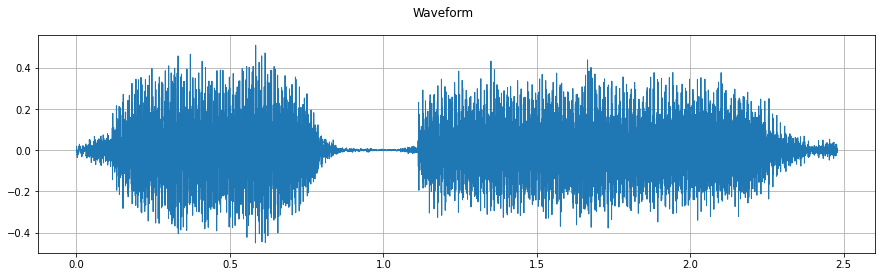

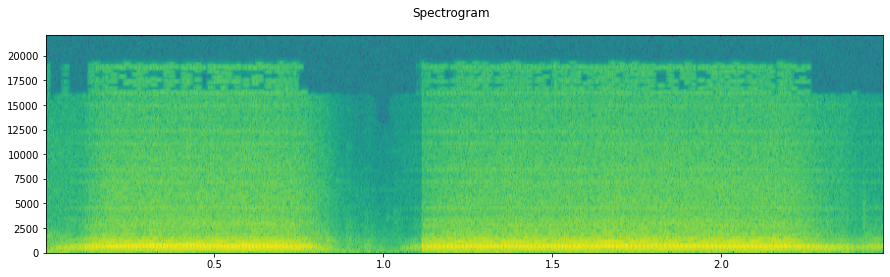

AudioMetaData(sample_rate=44100, num_frames=0, num_channels=2, bits_per_sample=0, encoding=MP3)


In [ ]:
SAMPLE_WAV_SPEECH_PATH1='/content/gdrive/MyDrive/project_folder/speech/_sample_data/bn.wav'
waveform, sample_rate = torchaudio.load(SAMPLE_WAV_SPEECH_PATH1)

print_stats(waveform, sample_rate=sample_rate)
plot_waveform(waveform, sample_rate)
plot_specgram(waveform, sample_rate)
play_audio(waveform, sample_rate)
print(metadata)

Loading from file-like object
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

``torchaudio``\ ’s I/O functions now support file-like object. This
allows to fetch audio data and decode at the same time from the location
other than local file system. The following examples illustrates this.




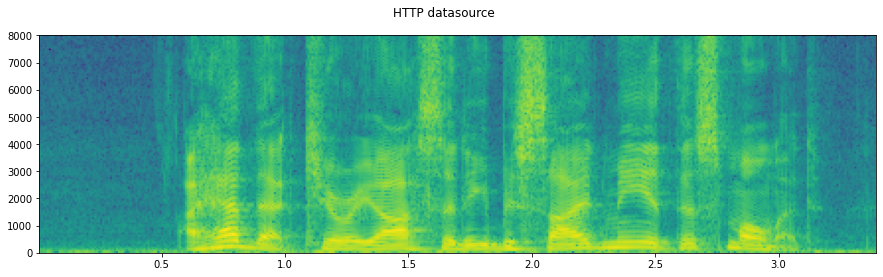

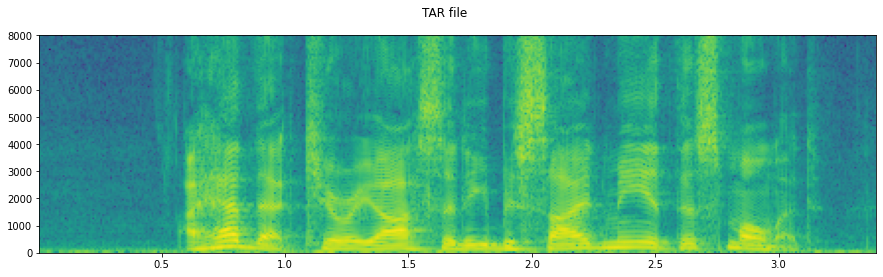

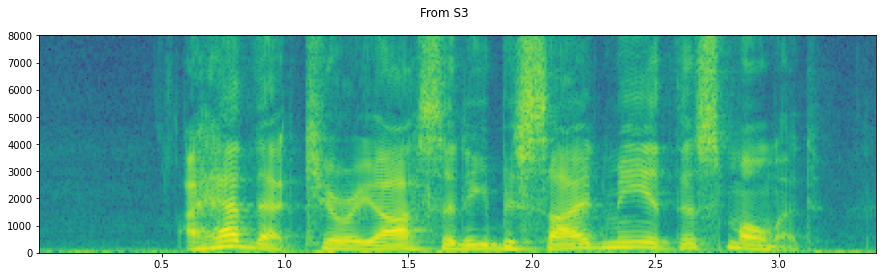

In [ ]:
# Load audio data as HTTP request
with requests.get(SAMPLE_WAV_SPEECH_URL, stream=True) as response:
  waveform, sample_rate = torchaudio.load(response.raw)
plot_specgram(waveform, sample_rate, title="HTTP datasource")

# Load audio from tar file
with tarfile.open(SAMPLE_TAR_PATH, mode='r') as tarfile_:
  fileobj = tarfile_.extractfile(SAMPLE_TAR_ITEM)
  waveform, sample_rate = torchaudio.load(fileobj)
plot_specgram(waveform, sample_rate, title="TAR file")

# Load audio from S3
client = boto3.client('s3', config=Config(signature_version=UNSIGNED))
response = client.get_object(Bucket=S3_BUCKET, Key=S3_KEY)
waveform, sample_rate = torchaudio.load(response['Body'])
plot_specgram(waveform, sample_rate, title="From S3")

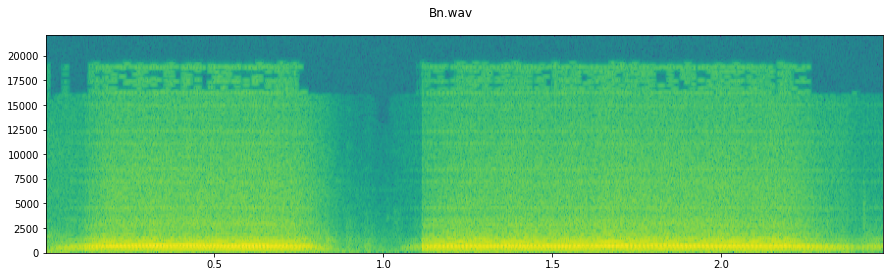

In [ ]:
waveform, sample_rate = torchaudio.load(SAMPLE_WAV_SPEECH_PATH)
plot_specgram(waveform, sample_rate, title="Bn.wav")
play_audio(waveform, sample_rate)

Tips on slicing
~~~~~~~~~~~~~~~

Providing ``num_frames`` and ``frame_offset`` arguments will slice the
resulting Tensor object while decoding.

The same result can be achieved using the regular Tensor slicing,
(i.e. ``waveform[:, frame_offset:frame_offset+num_frames]``) however,
providing ``num_frames`` and ``frame_offset`` arguments is more
efficient.

This is because the function will stop data acquisition and decoding
once it finishes decoding the requested frames. This is advantageous
when the audio data are transfered via network as the data transfer will
stop as soon as the necessary amount of data is fetched.

The following example illustrates this;




In [ ]:
# Illustration of two different decoding methods.
# The first one will fetch all the data and decode them, while
# the second one will stop fetching data once it completes decoding.
# The resulting waveforms are identical.

frame_offset, num_frames = 16000, 16000  # Fetch and decode the 1 - 2 seconds

print("Fetching all the data...")
with requests.get(SAMPLE_WAV_SPEECH_URL, stream=True) as response:
  waveform1, sample_rate1 = torchaudio.load(response.raw)
  waveform1 = waveform1[:, frame_offset:frame_offset+num_frames]
  print(f" - Fetched {response.raw.tell()} bytes")

print("Fetching until the requested frames are available...")
with requests.get(SAMPLE_WAV_SPEECH_URL, stream=True) as response:
  waveform2, sample_rate2 = torchaudio.load(
      response.raw, frame_offset=frame_offset, num_frames=num_frames)
  print(f" - Fetched {response.raw.tell()} bytes")

print("Checking the resulting waveform ... ", end="")
assert (waveform1 == waveform2).all()
print("matched!")

Fetching all the data...
 - Fetched 108844 bytes
Fetching until the requested frames are available...
 - Fetched 65580 bytes
Checking the resulting waveform ... matched!


Saving audio to file
--------------------

To save audio data in the formats intepretable by common applications,
you can use ``torchaudio.save``.

This function accepts path-like object and file-like object.

When passing file-like object, you also need to provide ``format``
argument so that the function knows which format it should be using. In
case of path-like object, the function will detemine the format based on
the extension. If you are saving to a file without extension, you need
to provide ``format`` argument.

When saving as WAV format, the default encoding for ``float32`` Tensor
is 32-bit floating-point PCM. You can provide ``encoding`` and
``bits_per_sample`` argument to change this. For example, to save data
in 16 bit signed integer PCM, you can do the following.

**Note** Saving data in encodings with lower bit depth reduces the
resulting file size but loses precision.




In [ ]:
waveform, sample_rate = get_sample()
print_stats(waveform, sample_rate=sample_rate)

# Save without any encoding option.
# The function will pick up the encoding which
# the provided data fit
#path = "save_example_default.wav"
path = SAMPLE_WAV_SPEECH_PATH
torchaudio.save(path, waveform, sample_rate)
inspect_file(path)

# Save as 16-bit signed integer Linear PCM
# The resulting file occupies half the storage but loses precision
path = "save_example_PCM_S16.wav"
torchaudio.save(
    path, waveform, sample_rate,
    encoding="PCM_S", bits_per_sample=16)
inspect_file(path)

Sample Rate: 44100
Shape: (1, 109368)
Dtype: torch.float32
 - Max:      0.508
 - Min:     -0.449
 - Mean:    -0.000
 - Std Dev:  0.122

tensor([[0.0027, 0.0063, 0.0092,  ..., 0.0032, 0.0047, 0.0052]])

----------
Source: /content/gdrive/MyDrive/project_folder/speech/_sample_data/bn.wav
----------
 - File size: 437530 bytes
 - AudioMetaData(sample_rate=44100, num_frames=109368, num_channels=1, bits_per_sample=32, encoding=PCM_F)
----------
Source: save_example_PCM_S16.wav
----------
 - File size: 218780 bytes
 - AudioMetaData(sample_rate=44100, num_frames=109368, num_channels=1, bits_per_sample=16, encoding=PCM_S)


``torchaudio.save`` can also handle other formats. To name a few;




In [ ]:
waveform, sample_rate = get_sample(resample=8000)

formats = [
  "mp3",
  "flac",
  "vorbis",
  "sph",
  "amb",
  "amr-nb",
  "gsm",
]

for format in formats:
  path = f"save_example.{format}"
  torchaudio.save(path, waveform, sample_rate, format=format)
  inspect_file(path)

----------
Source: save_example.mp3
----------
 - File size: 2664 bytes
 - AudioMetaData(sample_rate=8000, num_frames=21312, num_channels=1, bits_per_sample=0, encoding=MP3)
----------
Source: save_example.flac
----------
 - File size: 47315 bytes
 - AudioMetaData(sample_rate=8000, num_frames=19840, num_channels=1, bits_per_sample=24, encoding=FLAC)
----------
Source: save_example.vorbis
----------
 - File size: 9967 bytes
 - AudioMetaData(sample_rate=8000, num_frames=19840, num_channels=1, bits_per_sample=0, encoding=VORBIS)
----------
Source: save_example.sph
----------
 - File size: 80384 bytes
 - AudioMetaData(sample_rate=8000, num_frames=19840, num_channels=1, bits_per_sample=32, encoding=PCM_S)
----------
Source: save_example.amb
----------
 - File size: 79418 bytes
 - AudioMetaData(sample_rate=8000, num_frames=19840, num_channels=1, bits_per_sample=32, encoding=PCM_F)
----------
Source: save_example.amr-nb
----------
 - File size: 1618 bytes
 - AudioMetaData(sample_rate=8000, nu

Saving to file-like object
~~~~~~~~~~~~~~~~~~~~~~~~~~

Similar to the other I/O functions, you can save audio into file-like
object. When saving to file-like object, ``format`` argument is
required.




In [ ]:
waveform, sample_rate = get_sample()

# Saving to Bytes buffer
buffer_ = io.BytesIO()
torchaudio.save(buffer_, waveform, sample_rate, format="wav")

buffer_.seek(0)
print(buffer_.read(16))

b'RIFF\x12\xad\x06\x00WAVEfmt '


Resampling
==========

To resample an audio waveform from one freqeuncy to another, you can use
``transforms.Resample`` or ``functional.resample``.
``transforms.Resample`` precomputes and caches the kernel used for
resampling, while ``functional.resample`` computes it on the fly, so
using ``transforms.Resample`` will result in a speedup if resampling
multiple waveforms using the same parameters (see Benchmarking section).

Both resampling methods use `bandlimited sinc
interpolation <https://ccrma.stanford.edu/~jos/resample/>`__ to compute
signal values at arbitrary time steps. The implementation involves
convolution, so we can take advantage of GPU / multithreading for
performance improvements. When using resampling in multiple
subprocesses, such as data loading with multiple worker processes, your
application might create more threads than your system can handle
efficiently. Setting ``torch.set_num_threads(1)`` might help in this
case.

Because a finite number of samples can only represent a finite number of
frequencies, resampling does not produce perfect results, and a variety
of parameters can be used to control for its quality and computational
speed. We demonstrate these properties through resampling a logarithmic
sine sweep, which is a sine wave that increases exponentially in
frequency over time.

The spectrograms below show the frequency representation of the signal,
where the x-axis labels correspond to the frequency of the original
waveform (in log scale), the y-axis corresponds to the frequency of the
plotted waveform, and the color intensity refers to amplitude.




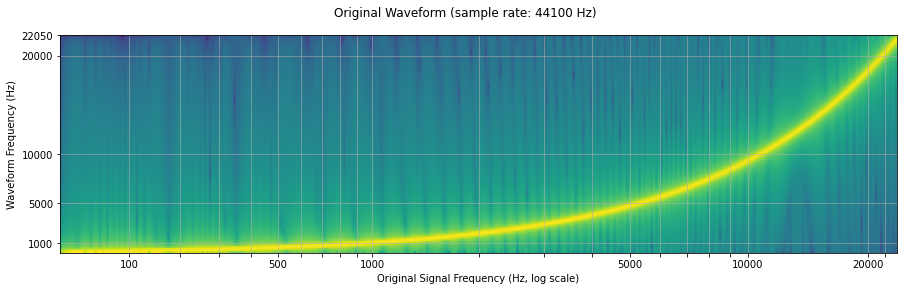

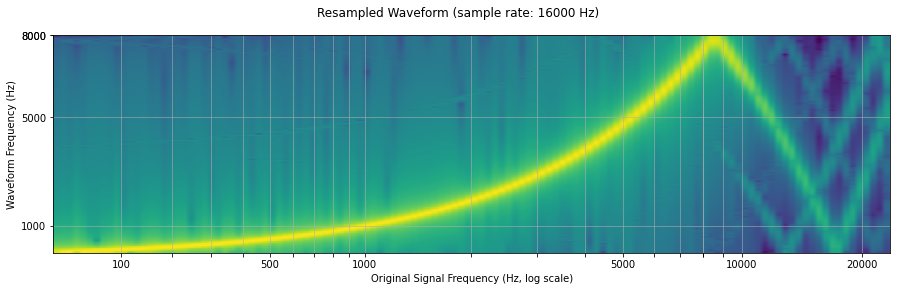

In [ ]:
SAMPLE_WAV_SPEECH_PATH='/content/gdrive/MyDrive/project_folder/speech/_sample_data/bn.wav'
waveform, sample_rate = torchaudio.load(SAMPLE_WAV_SPEECH_PATH)
#waveform, sample_rate = get_sample()
#print_stats(waveform, sample_rate=sample_rate)

#print_stats(waveform, sample_rate=sample_rate)
#sample_rate = get_sample()
#print_stats(sample_rate=sample_rate)

# Save without any encoding option.
# The function will pick up the encoding which
# the provided data fit
#path = "save_example_default.wav"
path = SAMPLE_WAV_SPEECH_PATH
torchaudio.load(path, sample_rate)

#sample_rate = 48000
resample_rate = 16000
#path = SAMPLE_WAV_SPEECH_PATH
#torchaudio.save(path, waveform, sample_rate)
#sample_rate = get_sample()
waveform = get_sine_sweep(sample_rate)
plot_sweep(waveform, sample_rate, title="Original Waveform")
play_audio(waveform, sample_rate)

resampler = T.Resample(sample_rate, resample_rate, dtype=waveform.dtype)
resampled_waveform = resampler(waveform)
plot_sweep(resampled_waveform, resample_rate, title="Resampled Waveform")
play_audio(waveform, sample_rate)

Controling resampling quality with parameters
---------------------------------------------

Lowpass filter width
~~~~~~~~~~~~~~~~~~~~

Because the filter used for interpolation extends infinitely, the
``lowpass_filter_width`` parameter is used to control for the width of
the filter to use to window the interpolation. It is also referred to as
the number of zero crossings, since the interpolation passes through
zero at every time unit. Using a larger ``lowpass_filter_width``
provides a sharper, more precise filter, but is more computationally
expensive.




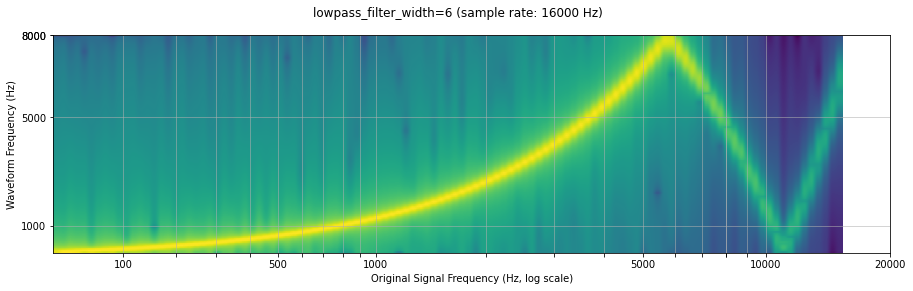

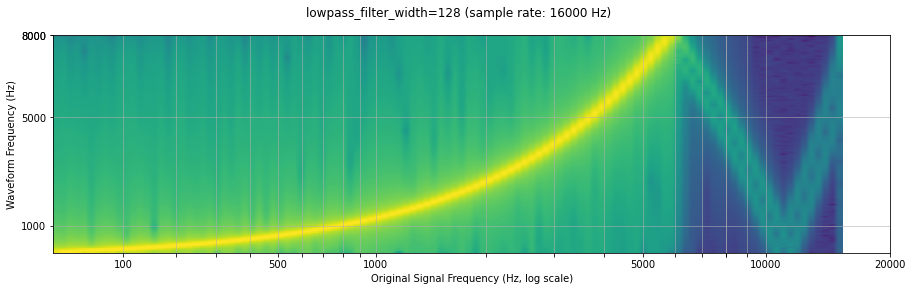

In [ ]:
sample_rate = 48000
resample_rate = 16000

resampled_waveform = F.resample(waveform, sample_rate, resample_rate, lowpass_filter_width=6)
plot_sweep(resampled_waveform, resample_rate, title="lowpass_filter_width=6")

resampled_waveform = F.resample(waveform, sample_rate, resample_rate, lowpass_filter_width=128)
plot_sweep(resampled_waveform, resample_rate, title="lowpass_filter_width=128")

Rolloff
~~~~~~~

The ``rolloff`` parameter is represented as a fraction of the Nyquist
frequency, which is the maximal frequency representable by a given
finite sample rate. ``rolloff`` determines the lowpass filter cutoff and
controls the degree of aliasing, which takes place when frequencies
higher than the Nyquist are mapped to lower frequencies. A lower rolloff
will therefore reduce the amount of aliasing, but it will also reduce
some of the higher frequencies.




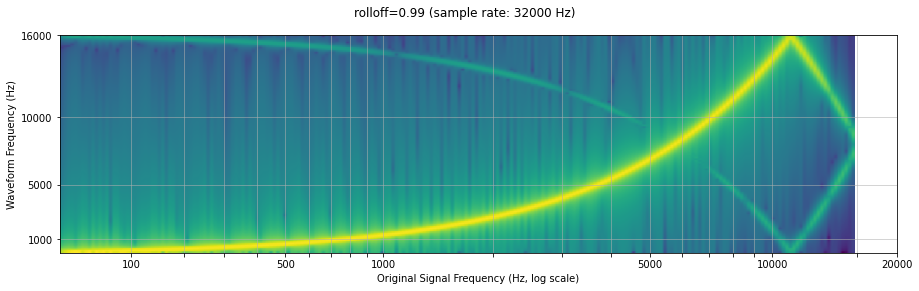

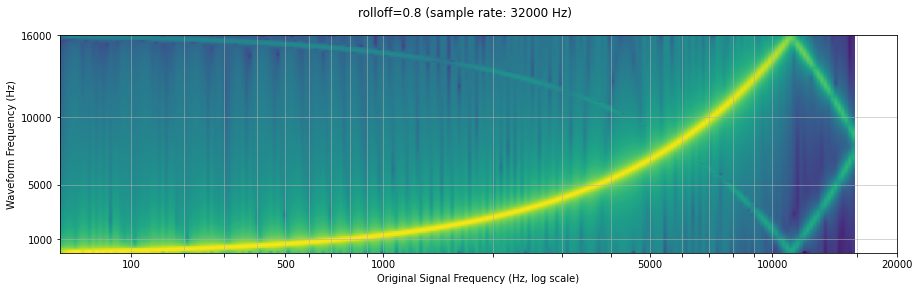

In [ ]:
sample_rate = 48000
resample_rate = 32000

resampled_waveform = F.resample(waveform, sample_rate, resample_rate, rolloff=0.99)
plot_sweep(resampled_waveform, resample_rate, title="rolloff=0.99")

resampled_waveform = F.resample(waveform, sample_rate, resample_rate, rolloff=0.8)
plot_sweep(resampled_waveform, resample_rate, title="rolloff=0.8")

Window function
~~~~~~~~~~~~~~~

By default, torchaudio’s resample uses the Hann window filter, which is
a weighted cosine function. It additionally supports the Kaiser window,
which is a near optimal window function that contains an additional
``beta`` parameter that allows for the design of the smoothness of the
filter and width of impulse. This can be controlled using the
``resampling_method`` parameter.




In [ ]:
sample_rate = 48000
resample_rate = 32000

resampled_waveform = F.resample(waveform, sample_rate, resample_rate, resampling_method="sinc_interpolation")
plot_sweep(resampled_waveform, resample_rate, title="Hann Window Default")

resampled_waveform = F.resample(waveform, sample_rate, resample_rate, resampling_method="kaiser_window")
plot_sweep(resampled_waveform, resample_rate, title="Kaiser Window Default")

Comparison against librosa
--------------------------

torchaudio’s resample function can be used to produce results similar to
that of librosa (resampy)’s kaiser window resampling, with some noise




In [ ]:
sample_rate = 48000
resample_rate = 32000

### kaiser_best
resampled_waveform = F.resample(
    waveform,
    sample_rate,
    resample_rate,
    lowpass_filter_width=64,
    rolloff=0.9475937167399596,
    resampling_method="kaiser_window",
    beta=14.769656459379492
)
plot_sweep(resampled_waveform, resample_rate, title="Kaiser Window Best (torchaudio)")

librosa_resampled_waveform = torch.from_numpy(
    librosa.resample(waveform.squeeze().numpy(), sample_rate, resample_rate, res_type='kaiser_best')).unsqueeze(0)
plot_sweep(librosa_resampled_waveform, resample_rate, title="Kaiser Window Best (librosa)")

mse = torch.square(resampled_waveform - librosa_resampled_waveform).mean().item()
print("torchaudio and librosa kaiser best MSE:", mse)

### kaiser_fast
resampled_waveform = F.resample(
    waveform,
    sample_rate,
    resample_rate,
    lowpass_filter_width=16,
    rolloff=0.85,
    resampling_method="kaiser_window",
    beta=8.555504641634386
)
plot_specgram(resampled_waveform, resample_rate, title="Kaiser Window Fast (torchaudio)")

librosa_resampled_waveform = torch.from_numpy(
    librosa.resample(waveform.squeeze().numpy(), sample_rate, resample_rate, res_type='kaiser_fast')).unsqueeze(0)
plot_sweep(librosa_resampled_waveform, resample_rate, title="Kaiser Window Fast (librosa)")

mse = torch.square(resampled_waveform - librosa_resampled_waveform).mean().item()
print("torchaudio and librosa kaiser fast MSE:", mse)

Performance Benchmarking
------------------------

Below are benchmarks for downsampling and upsampling waveforms between
two pairs of sampling rates. We demonstrate the performance implications
that the ``lowpass_filter_wdith``, window type, and sample rates can
have. Additionally, we provide a comparison against ``librosa``\ ’s
``kaiser_best`` and ``kaiser_fast`` using their corresponding parameters
in ``torchaudio``.

To elaborate on the results:
- a larger ``lowpass_filter_width`` results in a larger resampling kernel,
  and therefore increases computation time for both the kernel computation
  and convolution
- using ``kaiser_window`` results in longer computation times than the default
  ``sinc_interpolation`` because it is more complex to compute the intermediate
  window values - a large GCD between the sample and resample rate will result
  in a simplification that allows for a smaller kernel and faster kernel computation.




In [ ]:
configs = {
    "downsample (48 -> 44.1 kHz)": [48000, 44100],
    "downsample (16 -> 8 kHz)": [16000, 8000],
    "upsample (44.1 -> 48 kHz)": [44100, 48000],
    "upsample (8 -> 16 kHz)": [8000, 1600],
}

for label in configs:
  times, rows = [], []
  sample_rate = configs[label][0]
  resample_rate = configs[label][1]
  waveform = get_sine_sweep(sample_rate)

  # sinc 64 zero-crossings
  f_time = benchmark_resample("functional", waveform, sample_rate, resample_rate, lowpass_filter_width=64)
  t_time = benchmark_resample("transforms", waveform, sample_rate, resample_rate, lowpass_filter_width=64)
  times.append([None, 1000 * f_time, 1000 * t_time])
  rows.append(f"sinc (width 64)")

  # sinc 6 zero-crossings
  f_time = benchmark_resample("functional", waveform, sample_rate, resample_rate, lowpass_filter_width=16)
  t_time = benchmark_resample("transforms", waveform, sample_rate, resample_rate, lowpass_filter_width=16)
  times.append([None, 1000 * f_time, 1000 * t_time])
  rows.append(f"sinc (width 16)")

  # kaiser best
  lib_time = benchmark_resample("librosa", waveform, sample_rate, resample_rate, librosa_type="kaiser_best")
  f_time = benchmark_resample(
      "functional",
      waveform,
      sample_rate,
      resample_rate,
      lowpass_filter_width=64,
      rolloff=0.9475937167399596,
      resampling_method="kaiser_window",
      beta=14.769656459379492)
  t_time = benchmark_resample(
      "transforms",
      waveform,
      sample_rate,
      resample_rate,
      lowpass_filter_width=64,
      rolloff=0.9475937167399596,
      resampling_method="kaiser_window",
      beta=14.769656459379492)
  times.append([1000 * lib_time, 1000 * f_time, 1000 * t_time])
  rows.append(f"kaiser_best")

  # kaiser fast
  lib_time = benchmark_resample("librosa", waveform, sample_rate, resample_rate, librosa_type="kaiser_fast")
  f_time = benchmark_resample(
      "functional",
      waveform,
      sample_rate,
      resample_rate,
      lowpass_filter_width=16,
      rolloff=0.85,
      resampling_method="kaiser_window",
      beta=8.555504641634386)
  t_time = benchmark_resample(
      "transforms",
      waveform,
      sample_rate,
      resample_rate,
      lowpass_filter_width=16,
      rolloff=0.85,
      resampling_method="kaiser_window",
      beta=8.555504641634386)
  times.append([1000 * lib_time, 1000 * f_time, 1000 * t_time])
  rows.append(f"kaiser_fast")

  df = pd.DataFrame(times,
                    columns=["librosa", "functional", "transforms"],
                    index=rows)
  df.columns = pd.MultiIndex.from_product([[f"{label} time (ms)"],df.columns])
  display(df.round(2))

Data Augmentation
=================

``torchaudio`` provides a variety of ways to augment audio data.




Applying effects and filtering
------------------------------

``torchaudio.sox_effects`` module provides ways to apply filiters like
``sox`` command on Tensor objects and file-object audio sources
directly.

There are two functions for this;

-  ``torchaudio.sox_effects.apply_effects_tensor`` for applying effects
   on Tensor
-  ``torchaudio.sox_effects.apply_effects_file`` for applying effects on
   other audio source

Both function takes effects in the form of ``List[List[str]]``. This
mostly corresponds to how ``sox`` command works, but one caveat is that
``sox`` command adds some effects automatically, but torchaudio’s
implementation does not do that.

For the list of available effects, please refer to `the sox
documentation <http://sox.sourceforge.net/sox.html>`__.

**Tip** If you need to load and resample your audio data on-the-fly,
then you can use ``torchaudio.sox_effects.apply_effects_file`` with
``"rate"`` effect.

**Note** ``apply_effects_file`` accepts file-like object or path-like
object. Similar to ``torchaudio.load``, when the audio format cannot be
detected from either file extension or header, you can provide
``format`` argument to tell what format the audio source is.

**Note** This process is not differentiable.




In [ ]:
# Load the data
waveform1, sample_rate1 = get_sample(resample=16000)

# Define effects
effects = [
  ["lowpass", "-1", "300"], # apply single-pole lowpass filter
  ["speed", "0.8"],  # reduce the speed
                     # This only changes sample rate, so it is necessary to
                     # add `rate` effect with original sample rate after this.
  ["rate", f"{sample_rate1}"],
  ["reverb", "-w"],  # Reverbration gives some dramatic feeling
]

# Apply effects
waveform2, sample_rate2 = torchaudio.sox_effects.apply_effects_tensor(
    waveform1, sample_rate1, effects)

plot_waveform(waveform1, sample_rate1, title="Original", xlim=(-.1, 3.2))
plot_waveform(waveform2, sample_rate2, title="Effects Applied", xlim=(-.1, 3.2))
print_stats(waveform1, sample_rate=sample_rate1, src="Original")
print_stats(waveform2, sample_rate=sample_rate2, src="Effects Applied")

Note that the number of frames and number of channels are different from
the original after the effects. Let’s listen to the audio. Doesn’t it
sound more dramatic?




In [ ]:
plot_specgram(waveform1, sample_rate1, title="Original", xlim=(0, 3.04))
play_audio(waveform1, sample_rate1)
plot_specgram(waveform2, sample_rate2, title="Effects Applied", xlim=(0, 3.04))
play_audio(waveform2, sample_rate2)

Simulating room reverbration
----------------------------

`Convolution
reverb <https://en.wikipedia.org/wiki/Convolution_reverb>`__ is a
technique used to make a clean audio data sound like in a different
environment.

Using Room Impulse Response (RIR), we can make a clean speech sound like
uttered in a conference room.

For this process, we need RIR data. The following data are from VOiCES
dataset, but you can record one by your self. Just turn on microphone
and clap you hands.




In [ ]:
sample_rate = 8000

rir_raw, _ = get_rir_sample(resample=sample_rate)

plot_waveform(rir_raw, sample_rate, title="Room Impulse Response (raw)", ylim=None)
plot_specgram(rir_raw, sample_rate, title="Room Impulse Response (raw)")
play_audio(rir_raw, sample_rate)

First, we need to clean up the RIR. We extract the main impulse,
normalize the signal power, then flip the time axis.




In [ ]:
rir = rir_raw[:, int(sample_rate*1.01):int(sample_rate*1.3)]
rir = rir / torch.norm(rir, p=2)
rir = torch.flip(rir, [1])

print_stats(rir)
plot_waveform(rir, sample_rate, title="Room Impulse Response", ylim=None)

Then we convolve the speech signal with the RIR filter.




In [ ]:
speech, _ = get_speech_sample(resample=sample_rate)

speech_ = torch.nn.functional.pad(speech, (rir.shape[1]-1, 0))
augmented = torch.nn.functional.conv1d(speech_[None, ...], rir[None, ...])[0]

plot_waveform(speech, sample_rate, title="Original", ylim=None)
plot_waveform(augmented, sample_rate, title="RIR Applied", ylim=None)

plot_specgram(speech, sample_rate, title="Original")
play_audio(speech, sample_rate)

plot_specgram(augmented, sample_rate, title="RIR Applied")
play_audio(augmented, sample_rate)

Adding background noise
-----------------------

To add background noise to audio data, you can simply add audio Tensor
and noise Tensor. A commonly way to adjust the intensity of noise is to
change Signal-to-Noise Ratio (SNR).
[`wikipedia <https://en.wikipedia.org/wiki/Signal-to-noise_ratio>`__]

\begin{align}\mathrm{SNR} = \frac{P_\mathrm{signal}}{P_\mathrm{noise}}\end{align}

\begin{align}{\mathrm  {SNR_{{dB}}}}=10\log _{{10}}\left({\mathrm  {SNR}}\right)\end{align}




In [ ]:
sample_rate = 8000
speech, _ = get_speech_sample(resample=sample_rate)
noise, _ = get_noise_sample(resample=sample_rate)
noise = noise[:, :speech.shape[1]]

plot_waveform(noise, sample_rate, title="Background noise")
plot_specgram(noise, sample_rate, title="Background noise")
play_audio(noise, sample_rate)

speech_power = speech.norm(p=2)
noise_power = noise.norm(p=2)

for snr_db in [20, 10, 3]:
  snr = math.exp(snr_db / 10)
  scale = snr * noise_power / speech_power
  noisy_speech = (scale * speech + noise) / 2

  plot_waveform(noisy_speech, sample_rate, title=f"SNR: {snr_db} [dB]")
  plot_specgram(noisy_speech, sample_rate, title=f"SNR: {snr_db} [dB]")
  play_audio(noisy_speech, sample_rate)

Applying codec to Tensor object
-------------------------------

``torchaudio.functional.apply_codec`` can apply codecs to Tensor object.

**Note** This process is not differentiable.




In [ ]:
waveform, sample_rate = get_speech_sample(resample=8000)

plot_specgram(waveform, sample_rate, title="Original")
play_audio(waveform, sample_rate)

configs = [
    ({"format": "wav", "encoding": 'ULAW', "bits_per_sample": 8}, "8 bit mu-law"),
    ({"format": "gsm"}, "GSM-FR"),
    ({"format": "mp3", "compression": -9}, "MP3"),
    ({"format": "vorbis", "compression": -1}, "Vorbis"),
]
for param, title in configs:
  augmented = F.apply_codec(waveform, sample_rate, **param)
  plot_specgram(augmented, sample_rate, title=title)
  play_audio(augmented, sample_rate)

Simulating a phone recoding
---------------------------

Combining the previous techniques, we can simulate audio that sounds
like a person talking over a phone in a echoey room with people talking
in the background.




In [ ]:
sample_rate = 16000
speech, _ = get_speech_sample(resample=sample_rate)

plot_specgram(speech, sample_rate, title="Original")
play_audio(speech, sample_rate)

# Apply RIR
rir, _ = get_rir_sample(resample=sample_rate, processed=True)
speech_ = torch.nn.functional.pad(speech, (rir.shape[1]-1, 0))
speech = torch.nn.functional.conv1d(speech_[None, ...], rir[None, ...])[0]

plot_specgram(speech, sample_rate, title="RIR Applied")
play_audio(speech, sample_rate)

# Add background noise
# Because the noise is recorded in the actual environment, we consider that
# the noise contains the acoustic feature of the environment. Therefore, we add
# the noise after RIR application.
noise, _ = get_noise_sample(resample=sample_rate)
noise = noise[:, :speech.shape[1]]

snr_db = 8
scale = math.exp(snr_db / 10) * noise.norm(p=2) / speech.norm(p=2)
speech = (scale * speech + noise) / 2

plot_specgram(speech, sample_rate, title="BG noise added")
play_audio(speech, sample_rate)

# Apply filtering and change sample rate
speech, sample_rate = torchaudio.sox_effects.apply_effects_tensor(
  speech,
  sample_rate,
  effects=[
      ["lowpass", "4000"],
      ["compand", "0.02,0.05", "-60,-60,-30,-10,-20,-8,-5,-8,-2,-8", "-8", "-7", "0.05"],
      ["rate", "8000"],
  ],
)

plot_specgram(speech, sample_rate, title="Filtered")
play_audio(speech, sample_rate)

# Apply telephony codec
speech = F.apply_codec(speech, sample_rate, format="gsm")

plot_specgram(speech, sample_rate, title="GSM Codec Applied")
play_audio(speech, sample_rate)

Feature Extractions
===================

``torchaudio`` implements feature extractions commonly used in audio
domain. They are available in ``torchaudio.functional`` and
``torchaudio.transforms``.

``functional`` module implements features as a stand alone functions.
They are stateless.

``transforms`` module implements features in object-oriented manner,
using implementations from ``functional`` and ``torch.nn.Module``.

Because all the transforms are subclass of ``torch.nn.Module``, they can
be serialized using TorchScript.

For the complete list of available features, please refer to the
documentation. In this tutorial, we will look into conversion between
time domain and frequency domain (``Spectrogram``, ``GriffinLim``,
``MelSpectrogram``) and augmentation technique called SpecAugment.




Spectrogram
-----------

To get the frequency representation of audio signal, you can use
``Spectrogram`` transform.




In [ ]:
waveform, sample_rate = get_speech_sample()

n_fft = 1024
win_length = None
hop_length = 512

# define transformation
spectrogram = T.Spectrogram(
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
)
# Perform transformation
spec = spectrogram(waveform)

print_stats(spec)
plot_spectrogram(spec[0], title='torchaudio')

GriffinLim
----------

To recover a waveform from spectrogram, you can use ``GriffinLim``.




In [ ]:
torch.random.manual_seed(0)
waveform, sample_rate = get_speech_sample()
plot_waveform(waveform, sample_rate, title="Original")
play_audio(waveform, sample_rate)

n_fft = 1024
win_length = None
hop_length = 512

spec = T.Spectrogram(
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
)(waveform)

griffin_lim = T.GriffinLim(
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
)
waveform = griffin_lim(spec)

plot_waveform(waveform, sample_rate, title="Reconstructed")
play_audio(waveform, sample_rate)

Mel Filter Bank
---------------

``torchaudio.functional.create_fb_matrix`` can generate the filter bank
to convert frequency bins to Mel-scale bins.

Since this function does not require input audio/features, there is no
equivalent transform in ``torchaudio.transforms``.




In [ ]:
n_fft = 256
n_mels = 64
sample_rate = 6000

mel_filters = F.create_fb_matrix(
    int(n_fft // 2 + 1),
    n_mels=n_mels,
    f_min=0.,
    f_max=sample_rate/2.,
    sample_rate=sample_rate,
    norm='slaney'
)
plot_mel_fbank(mel_filters, "Mel Filter Bank - torchaudio")

Comparison against librosa
~~~~~~~~~~~~~~~~~~~~~~~~~~

As a comparison, here is the equivalent way to get the mel filter bank
with ``librosa``.




In [ ]:
mel_filters_librosa = librosa.filters.mel(
    sample_rate,
    n_fft,
    n_mels=n_mels,
    fmin=0.,
    fmax=sample_rate/2.,
    norm='slaney',
    htk=True,
).T

plot_mel_fbank(mel_filters_librosa, "Mel Filter Bank - librosa")

mse = torch.square(mel_filters - mel_filters_librosa).mean().item()
print('Mean Square Difference: ', mse)

MelSpectrogram
--------------

Mel-scale spectrogram is a combination of Spectrogram and mel scale
conversion. In ``torchaudio``, there is a transform ``MelSpectrogram``
which is composed of ``Spectrogram`` and ``MelScale``.




In [ ]:
waveform, sample_rate = get_speech_sample()

n_fft = 1024
win_length = None
hop_length = 512
n_mels = 128

mel_spectrogram = T.MelSpectrogram(
    sample_rate=sample_rate,
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
    norm='slaney',
    onesided=True,
    n_mels=n_mels,
    mel_scale="htk",
)

melspec = mel_spectrogram(waveform)
plot_spectrogram(
    melspec[0], title="MelSpectrogram - torchaudio", ylabel='mel freq')

Comparison against librosa
~~~~~~~~~~~~~~~~~~~~~~~~~~

As a comparison, here is the equivalent way to get Mel-scale spectrogram
with ``librosa``.




In [ ]:
melspec_librosa = librosa.feature.melspectrogram(
    waveform.numpy()[0],
    sr=sample_rate,
    n_fft=n_fft,
    hop_length=hop_length,
    win_length=win_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
    n_mels=n_mels,
    norm='slaney',
    htk=True,
)
plot_spectrogram(
    melspec_librosa, title="MelSpectrogram - librosa", ylabel='mel freq')

mse = torch.square(melspec - melspec_librosa).mean().item()
print('Mean Square Difference: ', mse)

MFCC
----




In [ ]:
waveform, sample_rate = get_speech_sample()

n_fft = 2048
win_length = None
hop_length = 512
n_mels = 256
n_mfcc = 256

mfcc_transform = T.MFCC(
    sample_rate=sample_rate,
    n_mfcc=n_mfcc,
    melkwargs={
      'n_fft': n_fft,
      'n_mels': n_mels,
      'hop_length': hop_length,
      'mel_scale': 'htk',
    }
)

mfcc = mfcc_transform(waveform)

plot_spectrogram(mfcc[0])

Comparing against librosa
~~~~~~~~~~~~~~~~~~~~~~~~~




In [ ]:
melspec = librosa.feature.melspectrogram(
  y=waveform.numpy()[0], sr=sample_rate, n_fft=n_fft,
  win_length=win_length, hop_length=hop_length,
  n_mels=n_mels, htk=True, norm=None)

mfcc_librosa = librosa.feature.mfcc(
  S=librosa.core.spectrum.power_to_db(melspec),
  n_mfcc=n_mfcc, dct_type=2, norm='ortho')

plot_spectrogram(mfcc_librosa)

mse = torch.square(mfcc - mfcc_librosa).mean().item()
print('Mean Square Difference: ', mse)

Pitch
-----




In [ ]:
waveform, sample_rate = get_speech_sample()

pitch = F.detect_pitch_frequency(waveform, sample_rate)
plot_pitch(waveform, sample_rate, pitch)
play_audio(waveform, sample_rate)

Kaldi Pitch (beta)
------------------

Kaldi Pitch feature [1] is pitch detection mechanism tuned for ASR
application. This is a beta feature in torchaudio, and only
``functional`` form is available.

1. A pitch extraction algorithm tuned for automatic speech recognition

   Ghahremani, B. BabaAli, D. Povey, K. Riedhammer, J. Trmal and S.
   Khudanpur

   2014 IEEE International Conference on Acoustics, Speech and Signal
   Processing (ICASSP), Florence, 2014, pp. 2494-2498, doi:
   10.1109/ICASSP.2014.6854049.
   [`abstract <https://ieeexplore.ieee.org/document/6854049>`__],
   [`paper <https://danielpovey.com/files/2014_icassp_pitch.pdf>`__]




In [ ]:
waveform, sample_rate = get_speech_sample(resample=16000)

pitch_feature = F.compute_kaldi_pitch(waveform, sample_rate)
pitch, nfcc = pitch_feature[..., 0], pitch_feature[..., 1]

plot_kaldi_pitch(waveform, sample_rate, pitch, nfcc)
play_audio(waveform, sample_rate)

Feature Augmentation
====================




SpecAugment
-----------

`SpecAugment <https://ai.googleblog.com/2019/04/specaugment-new-data-augmentation.html>`__
is a popular augmentation technique applied on spectrogram.

``torchaudio`` implements ``TimeStrech``, ``TimeMasking`` and
``FrequencyMasking``.




TimeStrech
~~~~~~~~~~




In [ ]:
spec = get_spectrogram(power=None)
strech = T.TimeStretch()

rate = 1.2
spec_ = strech(spec, rate)
plot_spectrogram(F.complex_norm(spec_[0]), title=f"Stretched x{rate}", aspect='equal', xmax=304)

plot_spectrogram(F.complex_norm(spec[0]), title="Original", aspect='equal', xmax=304)

rate = 0.9
spec_ = strech(spec, rate)
plot_spectrogram(F.complex_norm(spec_[0]), title=f"Stretched x{rate}", aspect='equal', xmax=304)

TimeMasking
~~~~~~~~~~~




In [ ]:
torch.random.manual_seed(4)

spec = get_spectrogram()
plot_spectrogram(spec[0], title="Original")

masking = T.TimeMasking(time_mask_param=80)
spec = masking(spec)

plot_spectrogram(spec[0], title="Masked along time axis")

FrequencyMasking
~~~~~~~~~~~~~~~~




In [ ]:
torch.random.manual_seed(4)

spec = get_spectrogram()
plot_spectrogram(spec[0], title="Original")

masking = T.FrequencyMasking(freq_mask_param=80)
spec = masking(spec)

plot_spectrogram(spec[0], title="Masked along frequency axis")

Datasets
========

``torchaudio`` provides easy access to common, publicly accessible
datasets. Please checkout the official documentation for the list of
available datasets.

Here, we take ``YESNO`` dataset and look into how to use it.




In [ ]:
YESNO_DOWNLOAD_PROCESS.join()

dataset = torchaudio.datasets.YESNO(YESNO_DATASET_PATH, download=True)

for i in [1, 3, 5]:
  waveform, sample_rate, label = dataset[i]
  plot_specgram(waveform, sample_rate, title=f"Sample {i}: {label}")
  play_audio(waveform, sample_rate)